# Градиентный бустинг своими руками

**Внимание:** в тексте задания произошли изменения - поменялось число деревьев (теперь 50), правило изменения величины шага в задании 3 и добавился параметр `random_state` у решающего дерева. Правильные ответы не поменялись, но теперь их проще получить. Также исправлена опечатка в функции `gbm_predict`.

В этом задании будет использоваться датасет `boston` из `sklearn.datasets`. Оставьте последние 25% объектов для контроля качества, разделив `X` и `y` на `X_train`, `y_train` и `X_test`, `y_test`.

Целью задания будет реализовать простой вариант градиентного бустинга над регрессионными деревьями для случая квадратичной функции потерь.

In [1]:
from sklearn import datasets, model_selection, tree, metrics, linear_model
import numpy as np

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
def write_answer(filename, result):
    with open(filename, "w") as f:
        f.write(str(result))

In [4]:
information_X_y = datasets.load_boston()

In [5]:
print(information_X_y.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [6]:
X = information_X_y.data
y = information_X_y.target

In [7]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, shuffle=False)

## Задание 1

Как вы уже знаете из лекций, **бустинг** - это метод построения композиций базовых алгоритмов с помощью последовательного добавления к текущей композиции нового алгоритма с некоторым коэффициентом. 

Градиентный бустинг обучает каждый новый алгоритм так, чтобы он приближал антиградиент ошибки по ответам композиции на обучающей выборке. Аналогично минимизации функций методом градиентного спуска, в градиентном бустинге мы подправляем композицию, изменяя алгоритм в направлении антиградиента ошибки.

Воспользуйтесь формулой из лекций, задающей ответы на обучающей выборке, на которые нужно обучать новый алгоритм (фактически это лишь чуть более подробно расписанный градиент от ошибки), и получите частный ее случай, если функция потерь `L` - квадрат отклонения ответа композиции `a(x)` от правильного ответа `y` на данном `x`.

Если вы давно не считали производную самостоятельно, вам поможет таблица производных элементарных функций (которую несложно найти в интернете) и правило дифференцирования сложной функции. После дифференцирования квадрата у вас возникнет множитель 2 — т.к. нам все равно предстоит выбирать коэффициент, с которым будет добавлен новый базовый алгоритм, проигноируйте этот множитель при дальнейшем построении алгоритма.

In [8]:
def coef_s(z, y): #z predict 
    return y-z

## Задание 2

Заведите массив для объектов `DecisionTreeRegressor` (будем их использовать в качестве базовых алгоритмов) и для вещественных чисел (это будут коэффициенты перед базовыми алгоритмами). 

В цикле от обучите последовательно 50 решающих деревьев с параметрами `max_depth=5` и `random_state=42` (остальные параметры - по умолчанию). В бустинге зачастую используются сотни и тысячи деревьев, но мы ограничимся 50, чтобы алгоритм работал быстрее, и его было проще отлаживать (т.к. цель задания разобраться, как работает метод). Каждое дерево должно обучаться на одном и том же множестве объектов, но ответы, которые учится прогнозировать дерево, будут меняться в соответствие с полученным в задании 1 правилом. 

Попробуйте для начала всегда брать коэффициент равным 0.9. Обычно оправдано выбирать коэффициент значительно меньшим - порядка 0.05 или 0.1, но т.к. в нашем учебном примере на стандартном датасете будет всего 50 деревьев, возьмем для начала шаг побольше.

В процессе реализации обучения вам потребуется функция, которая будет вычислять прогноз построенной на данный момент композиции деревьев на выборке `X`:

```
def gbm_predict(X):
    return [sum([coeff * algo.predict([x])[0] for algo, coeff in zip(base_algorithms_list, coefficients_list)]) for x in X]
(считаем, что base_algorithms_list - список с базовыми алгоритмами, coefficients_list - список с коэффициентами перед алгоритмами)
```

Эта же функция поможет вам получить прогноз на контрольной выборке и оценить качество работы вашего алгоритма с помощью `mean_squared_error` в `sklearn.metrics`. 

Возведите результат в степень 0.5, чтобы получить `RMSE`. Полученное значение `RMSE` — **ответ в пункте 2**.

In [9]:
def gbm_predict(X, base_algorithms_list, coefficients_list):
    return [sum([coeff * algo.predict([x])[0] for algo, coeff in zip(base_algorithms_list, coefficients_list)]) for x in X]

In [10]:
coefficients_list = np.array([0.9]*50) 

In [11]:
def grad_boost_with_tree(coefficients_list):
    b_0_predict = y_train.mean()
    s = coef_s(b_0_predict, y_train)
    base_algorithms_list = []
    for i in range(50):
        regressor  = tree.DecisionTreeRegressor(max_depth=5, random_state=42)
        b_i = regressor.fit(X_train, s)
        base_algorithms_list.append(b_i)
        s = coef_s(gbm_predict(X_train, base_algorithms_list, coefficients_list), y_train)  
        print("iteration: ", i)
        print("mean_squared_error: ", np.sqrt(metrics.mean_squared_error(y_test, gbm_predict(X_test, base_algorithms_list,
                                                                                            coefficients_list))))
    return base_algorithms_list

In [12]:
base_algorithms_list = grad_boost_with_tree(coefficients_list)

iteration:  0
mean_squared_error:  22.161742587779628
iteration:  1
mean_squared_error:  5.027239407062743
iteration:  2
mean_squared_error:  5.69192763915451
iteration:  3
mean_squared_error:  5.87435947834759
iteration:  4
mean_squared_error:  6.14752437553713
iteration:  5
mean_squared_error:  6.082896555240941
iteration:  6
mean_squared_error:  6.18102968768605
iteration:  7
mean_squared_error:  6.226749304492866
iteration:  8
mean_squared_error:  6.379941509292298
iteration:  9
mean_squared_error:  6.380420435221391
iteration:  10
mean_squared_error:  6.386843311832976
iteration:  11
mean_squared_error:  6.381158461530806
iteration:  12
mean_squared_error:  6.379420142955294
iteration:  13
mean_squared_error:  6.384959245085554
iteration:  14
mean_squared_error:  6.327079252977689
iteration:  15
mean_squared_error:  6.363221965372965
iteration:  16
mean_squared_error:  6.36191560432617
iteration:  17
mean_squared_error:  6.348160144330616
iteration:  18
mean_squared_error:  6.3570

In [13]:
pred_train2 = gbm_predict(X_train, base_algorithms_list, coefficients_list)

In [14]:
result_train2 = np.sqrt(metrics.mean_squared_error(y_train, pred_train2))

In [15]:
result_train2

0.0025838443027329074

In [16]:
pred_test2 = gbm_predict(X_test, base_algorithms_list, coefficients_list)

In [17]:
result_test2 = np.sqrt(metrics.mean_squared_error(y_test, pred_test2))

In [18]:
result_test2

6.360601652693612

In [19]:
write_answer("answer_2", result_test2)

## Задание 3

Вас может также беспокоить, что двигаясь с постоянным шагом, вблизи минимума ошибки ответы на обучающей выборке меняются слишком резко, перескакивая через минимум. 

Попробуйте уменьшать вес перед каждым алгоритмом с каждой следующей итерацией по формуле `0.9 / (1.0 + i)`, где `i` - номер итерации (от 0 до 49). Используйте качество работы алгоритма как **ответ в пункте 3**. 

В реальности часто применяется следующая стратегия выбора шага: как только выбран алгоритм, подберем коэффициент перед ним численным методом оптимизации таким образом, чтобы отклонение от правильных ответов было минимальным. Мы не будем предлагать вам реализовать это для выполнения задания, но рекомендуем попробовать разобраться с такой стратегией и реализовать ее при случае для себя.

In [20]:
coefficients_list = [coefficients_list[i]/(1 + i) for i in range(50)]

In [21]:
base_algorithms_list = grad_boost_with_tree(coefficients_list)

iteration:  0
mean_squared_error:  22.161742587779628
iteration:  1
mean_squared_error:  11.873054014470993
iteration:  2
mean_squared_error:  8.49483917280849
iteration:  3
mean_squared_error:  6.7348611402890475
iteration:  4
mean_squared_error:  5.882095948474044
iteration:  5
mean_squared_error:  5.4502795330659195
iteration:  6
mean_squared_error:  5.205119329655754
iteration:  7
mean_squared_error:  5.042989747437587
iteration:  8
mean_squared_error:  4.9677748145975595
iteration:  9
mean_squared_error:  4.93685932751897
iteration:  10
mean_squared_error:  4.9191816575361145
iteration:  11
mean_squared_error:  4.917502738964949
iteration:  12
mean_squared_error:  4.921536296223577
iteration:  13
mean_squared_error:  4.946481164389622
iteration:  14
mean_squared_error:  4.963631074184063
iteration:  15
mean_squared_error:  4.983850706917167
iteration:  16
mean_squared_error:  5.005154588341403
iteration:  17
mean_squared_error:  5.024837013494156
iteration:  18
mean_squared_error:

In [22]:
pred_test3 = gbm_predict(X_test, base_algorithms_list, coefficients_list)
result_test3 = np.sqrt(metrics.mean_squared_error(y_test, pred_test3))

In [23]:
result_test3

5.405149866038413

In [24]:
write_answer("answer_3", result_test3)

## Задание 4

Реализованный вами метод - градиентный бустинг над деревьями - очень популярен в машинном обучении. Он представлен как в самой библиотеке `sklearn`, так и в сторонней библиотеке `XGBoost`, которая имеет свой питоновский интерфейс. На практике `XGBoost` работает заметно лучше `GradientBoostingRegressor` из `sklearn`, но для этого задания вы можете использовать любую реализацию. 

Исследуйте, переобучается ли градиентный бустинг с ростом числа итераций (и подумайте, почему), а также с ростом глубины деревьев. На основе наблюдений выпишите через пробел номера правильных из приведенных ниже утверждений в порядке возрастания номера (это будет **ответ в п.4**):

    1. С увеличением числа деревьев, начиная с некоторого момента, качество работы градиентного бустинга не меняется существенно.

    2. С увеличением числа деревьев, начиная с некоторого момента, градиентный бустинг начинает переобучаться.

    3. С ростом глубины деревьев, начиная с некоторого момента, качество работы градиентного бустинга на тестовой выборке начинает ухудшаться.

    4. С ростом глубины деревьев, начиная с некоторого момента, качество работы градиентного бустинга перестает существенно изменяться

In [25]:
from sklearn.ensemble import GradientBoostingRegressor
n_est = np.arange(1, 100, 4)
print(n_est)

score_train = []
score_test = []
for n in n_est:
    reg = GradientBoostingRegressor(n_estimators=n)
    reg.fit(X_train, y_train)
    score_train.append(metrics.mean_squared_error(y_train, reg.predict(X_train)))
    score_test.append(metrics.mean_squared_error(y_test, reg.predict(X_test)))
    

[ 1  5  9 13 17 21 25 29 33 37 41 45 49 53 57 61 65 69 73 77 81 85 89 93
 97]


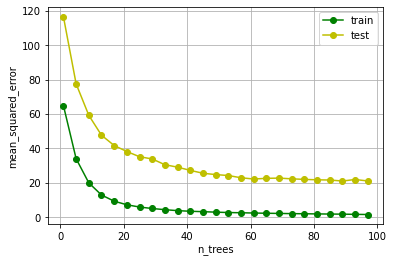

In [26]:
pylab.grid(True)
pylab.plot(n_est, score_train, 'g-', marker='o', label='train')
pylab.plot(n_est, score_test, 'y-', marker='o', label='test')
pylab.xlabel('n_trees')
pylab.ylabel('mean_squared_error')

pylab.legend(loc='upper right')

In [27]:
n_depth = np.arange(1, 50, 2)
print(n_depth)

score_train2 = []
score_test2 = []
for n in n_depth:
    reg = GradientBoostingRegressor(n_estimators=100, max_depth=n)
    reg.fit(X_train, y_train)
    score_train2.append(metrics.mean_squared_error(y_train, reg.predict(X_train)))
    score_test2.append(metrics.mean_squared_error(y_test, reg.predict(X_test)))

[ 1  3  5  7  9 11 13 15 17 19 21 23 25 27 29 31 33 35 37 39 41 43 45 47
 49]


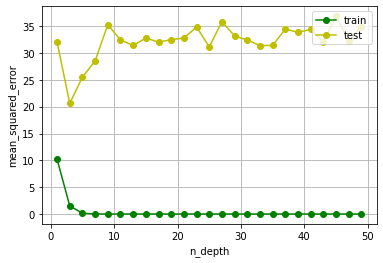

In [28]:
pylab.grid(True)
pylab.plot(n_depth, score_train2, 'g-', marker='o', label='train')
pylab.plot(n_depth, score_test2, 'y-', marker='o', label='test')
pylab.xlabel('n_depth')
pylab.ylabel('mean_squared_error')

pylab.legend(loc='upper right')

In [29]:
write_answer("answer_4", "2 3")

## Задание 5

Сравните получаемое с помощью градиентного бустинга качество с качеством работы линейной регрессии. 

Для этого обучите `LinearRegression` из `sklearn.linear_model` (с параметрами по умолчанию) на обучающей выборке и оцените для прогнозов полученного алгоритма на тестовой выборке `RMSE`. Полученное качество - ответ в **пункте 5**. 

В данном примере качество работы простой модели должно было оказаться хуже, но не стоит забывать, что так бывает не всегда. В заданиях к этому курсу вы еще встретите пример обратной ситуации.

In [30]:
def grad_boost_with_linear_model(coefficients_list):
    b_0_predict = y_train.mean()
    s = coef_s(b_0_predict, y_train)
    base_algorithms_list = []
    for i in range(50):
        regressor  = linear_model.LinearRegression()
        b_i = regressor.fit(X_train, s)
        base_algorithms_list.append(b_i)
        s = coef_s(gbm_predict(X_train, base_algorithms_list, coefficients_list), y_train)  
        print("iteration: ", i)
        print("mean_squared_error: ", np.sqrt(metrics.mean_squared_error(y_test, gbm_predict(X_test, base_algorithms_list,
                                                                                            coefficients_list))))
    return base_algorithms_list

In [31]:
coefficients_list

[0.9,
 0.45,
 0.3,
 0.225,
 0.18,
 0.15,
 0.1285714285714286,
 0.1125,
 0.1,
 0.09,
 0.08181818181818182,
 0.075,
 0.06923076923076923,
 0.0642857142857143,
 0.060000000000000005,
 0.05625,
 0.052941176470588235,
 0.05,
 0.04736842105263158,
 0.045,
 0.04285714285714286,
 0.04090909090909091,
 0.0391304347826087,
 0.0375,
 0.036000000000000004,
 0.03461538461538462,
 0.03333333333333333,
 0.03214285714285715,
 0.03103448275862069,
 0.030000000000000002,
 0.02903225806451613,
 0.028125,
 0.027272727272727275,
 0.026470588235294117,
 0.025714285714285714,
 0.025,
 0.024324324324324326,
 0.02368421052631579,
 0.023076923076923078,
 0.0225,
 0.021951219512195124,
 0.02142857142857143,
 0.020930232558139535,
 0.020454545454545454,
 0.02,
 0.01956521739130435,
 0.019148936170212766,
 0.01875,
 0.018367346938775512,
 0.018000000000000002]

In [32]:
base_algorithms_list = grad_boost_with_linear_model(coefficients_list)

iteration:  0
mean_squared_error:  19.002163938826264
iteration:  1
mean_squared_error:  8.8435011892595
iteration:  2
mean_squared_error:  6.0347693464785594
iteration:  3
mean_squared_error:  5.270883394534729
iteration:  4
mean_squared_error:  5.1988107577754725
iteration:  5
mean_squared_error:  5.3420043438516185
iteration:  6
mean_squared_error:  5.53822683922233
iteration:  7
mean_squared_error:  5.734654633720632
iteration:  8
mean_squared_error:  5.9153300807040745
iteration:  9
mean_squared_error:  6.07680414807888
iteration:  10
mean_squared_error:  6.219813977869305
iteration:  11
mean_squared_error:  6.346343777108607
iteration:  12
mean_squared_error:  6.458574542909174
iteration:  13
mean_squared_error:  6.558525058096736
iteration:  14
mean_squared_error:  6.647951698836096
iteration:  15
mean_squared_error:  6.72834387689747
iteration:  16
mean_squared_error:  6.800951838978507
iteration:  17
mean_squared_error:  6.866822227070688
iteration:  18
mean_squared_error:  6.

In [33]:
pred_train5 = gbm_predict(X_train, base_algorithms_list, coefficients_list)

In [34]:
pred_test5 = gbm_predict(X_test, base_algorithms_list, coefficients_list)

In [35]:
result_train5 = np.sqrt(metrics.mean_squared_error(y_train, pred_train5))

In [36]:
result_train5

4.639265382205194

In [37]:
result_test5 = np.sqrt(metrics.mean_squared_error(y_test, pred_test5))

In [38]:
result_test5

7.673062579891788

In [39]:
write_answer("answer_5", result_test5)